# Discrete Simulation Final Project
Authors: [Felipe Melo](https://github.com/FelipOliveira), [João Canavarro](https://github.com/jvcanavarro) and [Vitor Cantão](https://github.com/VitorCantao).

***
## Metro Bike [Dataset](https://bikeshare.metro.net/about/data/)
*The Metro Bike Share system makes bikes available 24/7, 365 days a year in Downtown LA, Central LA, and North Hollywood (...). Metro Bike Share offers convenient round-the-clock access to a fleet of bicycles for short trips. Metro Bike Share is one of LA Metro's multiple public transportation options for Angelenos and visitors to get around.*

In [1]:
import matplotlib.pyplot as plt
import geopy.distance as gd
import pandas as pd
import numpy as np

### Dataset Overview

In [96]:
df = pd.read_csv('../datasets/metrobike-2020.csv')
df.head()

/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
0,134867493,25,1/1/2020 0:16,1/1/2020 0:41,3063,34.048038,-118.253738,4491,34.047440,-118.247940,18419,30,One Way,Monthly Pass,electric
1,134867799,35,1/1/2020 0:24,1/1/2020 0:59,4285,NaN,NaN,4354,34.017681,-118.409081,15661,1,One Way,One Day Pass,smart
2,134868104,37,1/1/2020 0:31,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,15848,1,One Way,Walk-up,smart
3,134868103,36,1/1/2020 0:32,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,16053,1,One Way,Walk-up,smart
4,134868102,35,1/1/2020 0:33,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,15694,1,One Way,Walk-up,smart


In [3]:
# Number of rides in 2020
df.shape[0]

209974

In [4]:
df.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_station',
       'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon',
       'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type',
       'bike_type'],
      dtype='object')

In [98]:
# Remove unecessary columns
columns = ['duration', 'start_time', 'end_time', 'start_station', 'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon', 'bike_id', 'trip_route_category', 'bike_type']
df = df[columns]
df.head()

,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,trip_route_category,bike_type
0,25,1/1/2020 0:16,1/1/2020 0:41,3063,34.048038,-118.253738,4491,34.047440,-118.247940,18419,One Way,electric
1,35,1/1/2020 0:24,1/1/2020 0:59,4285,NaN,NaN,4354,34.017681,-118.409081,15661,One Way,smart
2,37,1/1/2020 0:31,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,15848,One Way,smart
3,36,1/1/2020 0:32,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,16053,One Way,smart
4,35,1/1/2020 0:33,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,15694,One Way,smart


####  According to Stations [Dataset](https://bikeshare.metro.net/wp-content/uploads/2021/01/metro-bike-share-stations-2021-01-01.csv):
* `4285,Metro Bike Share Free Bikes,2/27/2019,Free Bikes,Active`
* `4286,Metro Bike Share Out of Service Area Smart Bike,2/27/2019,Free Bikes,Active`
* `3000,Virtual Station,7/7/2016,N/A,Active`

Those stations doesn't possess geolocation information, which leads us to ignore then when calculating rides distances

In [99]:
df_null = df[df.isnull().any(axis=1)]
nan_stations = df_null.start_station[df_null['start_lat'].isnull()].unique()
nan_stations

array([4285, 4286, 3000])

In [100]:
# Remove stations without geolocation
df = df.dropna()

In [101]:
# Remove trips starting and ending at the same station
df = df.loc[df.trip_route_category == 'One Way']

In [9]:
# Total bikes within all stations and Nº of stations
print('Number of bicycles: ', len(df['bike_id'].unique()))
print('Number of stations: ', df['start_station'].unique().shape[0])

Number of bicycles:  3908
Number of stations:  263


In [102]:
# Percentage of rides by each model of bicycle
df['bike_type'].value_counts(normalize=True)

standard    0.519093
electric    0.412155
smart       0.068751
Name: bike_type, dtype: float64

In [11]:
# Mean duration of a bike travel
df['duration'].mean()

25.987537456780636

### Calculate distance using geolocation coordenates

In [12]:
def get_distance(coords):
    return gd.geodesic((coords[0], coords[1]), (coords[2], coords[3])).km

In [103]:
# Create new distance column
columns = ['start_lat', 'start_lon', 'end_lat', 'end_lon']
df['distance'] = df.apply(lambda x: get_distance(x[columns]), axis=1)

In [14]:
df.head()

,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,trip_route_category,bike_type,distance
0,25,1/1/2020 0:16,1/1/2020 0:41,3063,34.048038,-118.253738,4491,34.047440,-118.247940,18419,One Way,electric,0.539441
2,37,1/1/2020 0:31,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,15848,One Way,smart,5.819566
3,36,1/1/2020 0:32,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,16053,One Way,smart,5.819566
4,35,1/1/2020 0:33,1/1/2020 1:08,4344,34.014309,-118.491341,4322,34.005871,-118.429161,15694,One Way,smart,5.819566
5,18,1/1/2020 0:35,1/1/2020 0:53,4472,34.092602,-118.280930,4306,34.057652,-118.292183,18937,One Way,electric,4.013519


A better option was to filter unique pairs of start and end stations, then calculate the distances. It may be implemented in the future.

In [15]:
df[['duration', 'distance']].describe()

,duration,distance
count,130150.000000,130150.000000
mean,25.987537,3.501088
std,85.131912,138.625385
min,1.000000,0.106798
25%,7.000000,0.703135
50%,12.000000,1.145119
75%,22.000000,1.991158
max,1440.000000,9812.232301


The duration and distance values of rides are very discrepant (see the standard deviation). Eventually, there are cases where people stay with the bike an entire day and then return then to a station, which doesn't reflect the real time they spending at the ride.
In this sense, we decided to ignore those cases when calculating the mean speed of each bycicle model.

### Calculate the average speed of each bicycle model with different intervals of time and space


In [16]:
# Select only necessary columns
time_space = df.iloc[:, [0, 11, 12]]
time_space.head()

,duration,bike_type,distance
0,25,electric,0.539441
2,37,smart,5.819566
3,36,smart,5.819566
4,35,smart,5.819566
5,18,electric,4.013519


In [17]:
def get_speed(space, time, unit):

    if unit == 'km/min': return space / time
    if unit == 'km/h'  : return space / (time / 60)
    if unit == 'm/s'   : return (space * 1000) / (time * 60)
    
unit = 'km/min'

In [181]:
intervals = [(0, 0), (15, 3), (30, 6), (45, 9), (120, 12)]
distance = 0
avg_speed = pd.DataFrame()

for x, y in zip(intervals, intervals[1:]):
    title = f'{x[0]} - {y[0]} Min'
    # Loc the intervals of duration and distance in order to calculate the speed of each model at these situations
    time_space_filtered = time_space.loc[(df.duration > x[0]) & (df.duration <= y[0]) 
                                           & (df.distance > x[1]) & (df.distance <= y[1])]
    time_space_filtered['speed'] = time_space_filtered.apply(lambda x: get_speed(x['distance'], x['duration'], unit=unit), axis=1)
    
    bike_speed = time_space_filtered.groupby('bike_type').mean()
    avg_speed[title] = bike_speed['speed']
    distance += 3

avg_speed

<ipython-input-181-3fb028c5f8fd>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_space_filtered['speed'] = time_space_filtered.apply(lambda x: get_speed(x['distance'], x['duration'], unit=unit), axis=1)
<ipython-input-181-3fb028c5f8fd>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_space_filtered['speed'] = time_space_filtered.apply(lambda x: get_speed(x['distance'], x['duration'], unit=unit), axis=1)
<ipython-input-181-3fb028c5f8fd>:10: SettingWithCopyWarning: 
A value is trying to be set on

,0 - 15 Min,15 - 30 Min,30 - 45 Min,45 - 120 Min
bike_type,,,,
electric,0.150663,0.189687,0.195431,0.172981
smart,0.154922,0.170135,0.184358,0.114980
standard,0.145599,0.175797,0.185172,0.154657


In [182]:
# Calculate average speed of each bike model

time_space_filtered = time_space.loc[(df.duration > 0) & (df.duration <= 180) 
                                           & (df.distance > 0) & (df.distance <= 12)]

time_space['speed'] = time_space_filtered.apply(lambda x: get_speed(x.distance, x.duration, unit), axis=1)
bike_speed = time_space.groupby('bike_type').mean()
avg_speed['Overall'] = bike_speed['speed']

We are only considering trips with duration and distance up to 120 minutes and 12 kilometers, respectively.

Idea: Create a 1st histogram that represents the normal distribuition of trips duration

Then, create a 2nd histogram that represents each bike model speed based on trips duration

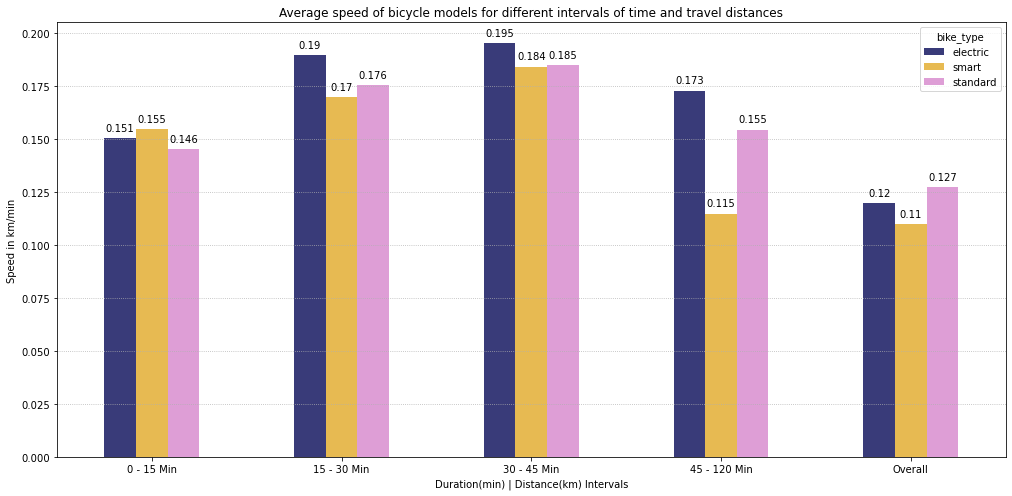

In [183]:
title = 'Average speed of bicycle models for different intervals of time and travel distances'
xlabel = 'Duration(min) | Distance(km) Intervals'

ax = avg_speed.T.plot(kind='bar', figsize=(17, 8), xlabel=xlabel, ylabel='Speed in ' + unit, colormap='tab20b', rot=0, title=title)
for p in ax.patches:                 
    ax.annotate(round(p.get_height(),3), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.grid(linestyle=':', axis='y')

it is noticeable that electric bicycles have a certain "advantage" over ordinary ones as the distance and duration of the rides increases

#### Normalize the frequency of rides for each unique pair of (start|end) station

In [21]:
# Ignore rides that end at same station and calculate total ocurrences by each ride
group = ['start_station', 'end_station', 'distance']
stations = df.groupby(group).size().reset_index(name='occurs')

# Normalize weights by each group (i.e. each start_station)
stations['norm_rides'] = stations['occurs'] / stations.groupby('start_station')['occurs'].transform('sum')
stations = stations.drop_duplicates(['start_station', 'end_station'])
stations

,start_station,end_station,distance,occurs,norm_rides
0,3005,3006,0.370922,318,0.048855
1,3005,3007,0.425258,82,0.012598
2,3005,3008,0.440409,124,0.019051
3,3005,3010,1.314694,32,0.004916
4,3005,3011,1.195366,71,0.010908
...,...,...,...,...,...
12137,4583,4544,5.516950,1,0.027778
12138,4583,4545,3.367619,1,0.027778
12139,4583,4577,1.894783,2,0.055556
12140,4583,4580,1.018363,1,0.027778


#### Create frequency and distance matrices

In [22]:
# Pivot to create rides frequency matrix
freq_matrix = stations.pivot(index='start_station', columns='end_station', values='norm_rides').fillna(0)
freq_matrix

end_station,3005,3006,3007,3008,3010,3011,3014,3016,3018,3019,...,4568,4569,4570,4571,4572,4573,4577,4580,4582,4583
start_station,,,,,,,,,,,,,,,,,,,,,
3005,0.000000,0.048855,0.012598,0.019051,0.004916,0.010908,0.006606,0.000154,0.017821,0.014902,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000
3006,0.112666,0.000000,0.021170,0.024758,0.002512,0.003229,0.011482,0.001076,0.019017,0.020811,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000
3007,0.079093,0.041692,0.000000,0.005518,0.000000,0.009197,0.007971,0.001226,0.025138,0.012876,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000
3008,0.086839,0.034520,0.005933,0.000000,0.001618,0.019957,0.004315,0.000000,0.008630,0.008091,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000
3010,0.087542,0.070707,0.003367,0.050505,0.000000,0.000000,0.023569,0.003367,0.016835,0.016835,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4573,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.111111,0.0,0.0,0.333333,0.0,0.0,0.000000,0.000000,0.000000,0.00000
4577,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.125000,0.000000,0.00000
4580,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.250000,0.000000,0.000000,0.00000


In [23]:
# Stations distance matrix
distance_matrix = stations.pivot(index='start_station', columns='end_station', values='distance').fillna(0)
distance_matrix.head()

end_station,3005,3006,3007,3008,3010,3011,3014,3016,3018,3019,...,4568,4569,4570,4571,4572,4573,4577,4580,4582,4583
start_station,,,,,,,,,,,,,,,,,,,,,
3005,0.000000,0.370922,0.425258,0.440409,1.314694,1.195366,2.164585,1.641468,0.549178,1.117860,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3006,0.370922,0.000000,0.580489,0.572496,0.956511,1.153563,2.175862,1.616011,0.378074,0.860632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3007,0.425258,0.580489,0.000000,0.865427,0.000000,1.613698,1.742760,1.232670,0.906916,1.438201,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3008,0.440409,0.572496,0.865427,0.000000,1.285645,0.777609,2.604177,0.000000,0.399279,0.904462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3010,1.314694,0.956511,1.490136,1.285645,0.000000,0.000000,2.714000,2.144889,0.886902,0.579519,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# Normalize start stations
start_station_matrix = df.start_station.value_counts(normalize=True)
start_station_matrix.head()

3005    0.050012
3035    0.031894
3030    0.030519
3014    0.022374
3006    0.021414
Name: start_station, dtype: float64

In [25]:
avg_speed.at['standard', (15, 3)]

0.1455985469080528

***
#### Simulation


In [26]:
def reset():
    stations = []
    total_clients = 0
    total_wait_time = 0
    total_overflow = 0

In [104]:
from enum import Enum
import simpy
import random

STATIONS = freq_matrix.index
destinations_matrix = freq_matrix.loc[STATIONS, STATIONS]
BIKE_TYPE = df['bike_type'].unique()

NUMBER_OF_RIDES = 209974
RIDES_PER_DAY = round(NUMBER_OF_RIDES / 365)
NUMBER_OF_BIKES = 3908
NUMBER_OF_STATIONS = len(STATIONS)
NUMBER_OF_BIKES_PER_STATION = NUMBER_OF_BIKES // NUMBER_OF_STATIONS
INTERVALS = [(0, 0), (15, 3), (30, 6), (45, 9), (120, 12)]

SHOULD_PRINT_EVENT = False

def random_weighted(vector):
    PRECISION = 10**6
    integer_vector = round(vector * PRECISION)
    pool_size = integer_vector.sum()

    random_number = random.randrange(0, pool_size)

    accumulated_probability = 0
    for index, item in enumerate(integer_vector):
        accumulated_probability += item
        if (random_number < accumulated_probability):
            return index

class BikeType(Enum):
    STANDARD = 1
    ELECTRIC = 2
    SMART = 3

class BikeDock:
    def __init__(self, env, standard_bikes, electric_bikes, smart_bikes, capacity):
        self.env = env
        self._standard_dock = simpy.Container(self.env, init=standard_bikes, capacity=capacity)
        self._electric_dock = simpy.Container(self.env, init=electric_bikes, capacity=capacity)
        self._smart_dock = simpy.Container(self.env, init=smart_bikes, capacity=capacity)
        self._type_to_dock = {BikeType.STANDARD: self._standard_dock, BikeType.ELECTRIC: self._electric_dock, BikeType.SMART: self._smart_dock}

    def capacity(self, bike_type):
        return self._type_to_dock[bike_type].capacity

    def available_bikes(self, bike_type):
        return self._type_to_dock[bike_type].level

    def has_available(self, bike_type):
        return self._type_to_dock[bike_type].level > 0

    def is_full(self, bike_type):
        return self._type_to_dock[bike_type].level >= self._type_to_dock[bike_type].capacity

    def rent_bike(self, bike_type):
        return self._type_to_dock[bike_type].get(1)

    def return_bike(self, bike_type):
        return self._type_to_dock[bike_type].put(1)


class Ride:
    def __init__(self, env, start_station, end_station, bike_type):
        self.start_station = start_station
        self.end_station = end_station
        self.bike_type = bike_type
        self._type_to_speed = {BikeType.STANDARD: 0.127, BikeType.ELECTRIC: 0.12, BikeType.SMART: 0.11}
        self.env = env

    @property
    def distance(self):
        return distance_matrix.at[self.start_station.id, self.end_station.id]

    @property
    def duration(self):
        return round(self.distance / self._bike_speed)

    def start(self):
        env.process(self.start_station.get_bike(self.bike_type))
        yield env.timeout(self.duration)
        env.process(self.end_station.put_bike(self.bike_type))

    @property
    def _bike_speed(self):
        bike_model = self.bike_type.name.lower()
        for x, y in zip(INTERVALS, INTERVALS[1:]):
            if x[0] < self.distance <= y[0]:
                return avg_speed.at[bike_model, y]
        return avg_speed.at[bike_model, 'overall']


class Station(object):
    def __init__(self, env, station_id):
        self.env = env
        self.id = station_id

        standard_bikes = round(NUMBER_OF_BIKES_PER_STATION * 0.4)
        electric_bikes = round(NUMBER_OF_BIKES_PER_STATION * 0.4)
        smart_bikes = round(NUMBER_OF_BIKES_PER_STATION * 0.2)
        self.dock = BikeDock(env, standard_bikes, electric_bikes, smart_bikes, 
                             capacity=NUMBER_OF_BIKES_PER_STATION * 1.05)

        self.overflow_count = 0
        self.client_wait_time = 0
        self.client_giveup = 0
        self.rides = 0

    def get_bike(self, bike_type):
        wait_time = 0
        while (wait_time < 10):
            if (self.dock.has_available(bike_type)):
                if (SHOULD_PRINT_EVENT): print(f'''Bike requested at station {self.id} - 
                {self.dock.available_bikes(bike_type) - 1} / {self.dock.capacity(bike_type)}''')

                self.rides += 1
                return self.dock.rent_bike(bike_type)
            else: 
                wait_time += 1
                self.client_wait_time += 1
                if (SHOULD_PRINT_EVENT): print(f'No more bikes at station {self.id}. Waiting {wait_time}...')
                yield env.timeout(1)
        self.client_giveup += 1
        if (SHOULD_PRINT_EVENT): print('#-#-#  I\'m out of here! Trash company!  #-#-#')
        

    def put_bike(self, bike_type):
        if (self.dock.is_full(bike_type)):
            self.overflow_count += 1

        if (SHOULD_PRINT_EVENT): print(f'''Bike arrived at station {self.id} - 
        {self.dock.available_bikes(bike_type) + 1} / {self.dock.capacity(bike_type)}''')

        yield self.dock.return_bike(bike_type)

def cyclist_arrivals(env, stations):
    random_station_index = random.randint(0, len(stations) - 1)
    start_station = stations[random_station_index]

    random_destination_index = random_weighted(destinations_matrix.loc[start_station.id])
    final_station = stations[random_destination_index]
    if (SHOULD_PRINT_EVENT): print(f'New Ciclist arrives! {start_station.id} -> {final_station.id}')

    bike_probability = df['bike_type'].value_counts(normalize=True)
    preferred_bike_type = BikeType(random_weighted(bike_probability) + 1)
    if (SHOULD_PRINT_EVENT): print(f'Preferred Bike Type: {preferred_bike_type}')

    ride = Ride(env, start_station, final_station, preferred_bike_type)
    yield env.process(ride.start())


def setup(env):
    global total_clients
    for station_id in STATIONS:
        stations.append(Station(env, station_id))
    while True:
        yield env.timeout(random.randint(1, 2))
        total_clients += 1
        env.process(cyclist_arrivals(env, stations))



total_clients = 0
total_wait_time = 0
total_overflow = 0
for i in range(30):
    print('Iteration: ',i+1)
    stations = []
    
    env = simpy.Environment()
    env.process(setup(env))
    env.run(until=1440)

    for station in stations:
        total_wait_time += station.client_wait_time
        total_overflow += station.overflow_count


    print(f'Total wait time: {total_wait_time}')
    print(f'Overflows: {total_overflow}')
    print(f'Trips: {total_clients}')

Iteration:  1
Total wait time: 0
Overflows: 0
Trips: 963
Iteration:  2
Total wait time: 0
Overflows: 0
Trips: 1922
Iteration:  3
Total wait time: 0
Overflows: 0
Trips: 2886
Iteration:  4
Total wait time: 0
Overflows: 0
Trips: 3834
Iteration:  5
Total wait time: 0
Overflows: 0
Trips: 4810
Iteration:  6
Total wait time: 0
Overflows: 0
Trips: 5765
Iteration:  7
Total wait time: 10
Overflows: 0
Trips: 6727
Iteration:  8
Total wait time: 10
Overflows: 0
Trips: 7688
Iteration:  9
Total wait time: 25
Overflows: 0
Trips: 8651
Iteration:  10
Total wait time: 25
Overflows: 0
Trips: 9626
Iteration:  11
Total wait time: 25
Overflows: 0
Trips: 10594
Iteration:  12
Total wait time: 25
Overflows: 0
Trips: 11557
Iteration:  13
Total wait time: 25
Overflows: 0
Trips: 12513
Iteration:  14
Total wait time: 45
Overflows: 0
Trips: 13476
Iteration:  15
Total wait time: 45
Overflows: 0
Trips: 14450
Iteration:  16
Total wait time: 45
Overflows: 0
Trips: 15416
Iteration:  17
Total wait time: 65
Overflows: 0
Tr

In [43]:
# Initial Simulation
ITERATIONS = 30

hipos = []
h1 = []

mean_trips = total_clients / ITERATIONS
n_bikes = NUMBER_OF_BIKES
mean_overflows = total_overflow / ITERATIONS
iterations = ITERATIONS
mean_w_time = total_wait_time / ITERATIONS
distr_bikes = (.5, .3, .2)
arrival_interval = 2.5

h1.append(mean_trips)
h1.append(n_bikes)
h1.append(mean_overflows)
h1.append(iterations)
h1.append(mean_w_time)
h1.append(arrival_interval)
h1.append(distr_bikes)

h1

[574.5666666666667,
 3908,
 1.0333333333333334,
 30,
 4.166666666666667,
 2.5,
 (0.5, 0.3, 0.2)]

In [50]:
hipos = []
hipos.append(h1)

[[574.5666666666667,
  3908,
  1.0333333333333334,
  30,
  4.166666666666667,
  2.5,
  (0.5, 0.3, 0.2)]]

In [52]:
# Reducing nº of bikes by half
h2 = []

mean_trips = total_clients / ITERATIONS
n_bikes = NUMBER_OF_BIKES
mean_overflows = total_overflow / ITERATIONS
iterations = ITERATIONS
mean_w_time = total_wait_time / ITERATIONS
distr_bikes = (.5, .3, .2)
arrival_interval = 2.5

h2.append(mean_trips)
h2.append(n_bikes)
h2.append(mean_overflows)
h2.append(iterations)
h2.append(mean_w_time)
h2.append(arrival_interval)
h2.append(distr_bikes)

hipos.append(h2)

In [107]:
print(h1)
print(h2)
print(h3)
print(h4)
print(h5)
print(h6)
print(h7)
print(h8)
print(h9)
print(h10)
print(h11)
print(h12)
print(h13)

[574.5666666666667, 3908, 1.0333333333333334, 30, 4.166666666666667, 2.5, (0.5, 0.3, 0.2)]
[574.2333333333333, 1954.0, 21.9, 30, 166.33333333333334, 2.5, (0.5, 0.3, 0.2)]
[575.8, 1954.0, 13.433333333333334, 30, 95.33333333333333, 2.5, (0.4, 0.4, 0.2)]
[577.2333333333333, 1954.0, 16.5, 30, 240.43333333333334, 2.5, (0.3, 0.5, 0.2)]
[573.6333333333333, 1954.0, 0.0, 30, 251.1, 2.5, (0.3, 0.5, 0.2)]
[719.7333333333333, 1954.0, 26.633333333333333, 30, 191.73333333333332, 2.0, (0.4, 0.4, 0.2)]
[960.5, 1954.0, 58.5, 30, 391.6, 1.5, (0.4, 0.4, 0.2)]
[575.2333333333333, 1954.0, 10.233333333333333, 30, 259.56666666666666, 2.5, (0.3, 0.4, 0.3)]
[958.5666666666667, 3908, 11.766666666666667, 30, 32.56666666666667, 1.5, (0.5, 0.3, 0.2)]
[1439.0, 3908, 33.5, 30, 128.93333333333334, 1.0, (0.5, 0.3, 0.2)]
[1439.0, 3908, 33.1, 30, 43.4, 1.0, (0.4, 0.4, 0.2)]
[1439.0, 3908, 0.0, 30, 36.266666666666666, 1.0, (0.4, 0.4, 0.2)]
[961.7, 3908, 0.0, 30, 3.5, 1.5, (0.4, 0.4, 0.2)]


In [56]:
# Reducing wait time with reduced number of bikes by changing bike model distr
h3 = []

mean_trips = total_clients / ITERATIONS
n_bikes = NUMBER_OF_BIKES
mean_overflows = total_overflow / ITERATIONS
iterations = ITERATIONS
mean_w_time = total_wait_time / ITERATIONS
distr_bikes = (.4, .4, .2)
arrival_interval = 2.5

h3.append(mean_trips)
h3.append(n_bikes)
h3.append(mean_overflows)
h3.append(iterations)
h3.append(mean_w_time)
h3.append(arrival_interval)
h3.append(distr_bikes)

hipos.append(h3)

In [60]:
# Reducing wait time with reduced number of bikes by changing bike model distr (2)
h4 = []

mean_trips = total_clients / ITERATIONS
n_bikes = NUMBER_OF_BIKES
mean_overflows = total_overflow / ITERATIONS
iterations = ITERATIONS
mean_w_time = total_wait_time / ITERATIONS
distr_bikes = (.3, .5, .2)
arrival_interval = 2.5

h4.append(mean_trips)
h4.append(n_bikes)
h4.append(mean_overflows)
h4.append(iterations)
h4.append(mean_w_time)
h4.append(arrival_interval)
h4.append(distr_bikes)

hipos.append(h4)

In [63]:
# Reducing wait time with reduced number of bikes by changing bike model distr and capacity by 20 %(3)
h5 = []

mean_trips = total_clients / ITERATIONS
n_bikes = NUMBER_OF_BIKES
mean_overflows = total_overflow / ITERATIONS
iterations = ITERATIONS
mean_w_time = total_wait_time / ITERATIONS
distr_bikes = (.3, .5, .2)
arrival_interval = 2.5

h5.append(mean_trips)
h5.append(n_bikes)
h5.append(mean_overflows)
h5.append(iterations)
h5.append(mean_w_time)
h5.append(arrival_interval)
h5.append(distr_bikes)

hipos.append(h5)

In [66]:
# Reducing wait time with reduced number of bikes by changing bike model distr and reducing arrival interval
h6 = []

mean_trips = total_clients / ITERATIONS
n_bikes = NUMBER_OF_BIKES
mean_overflows = total_overflow / ITERATIONS
iterations = ITERATIONS
mean_w_time = total_wait_time / ITERATIONS
distr_bikes = (.4, .4, .2)
arrival_interval = 2.0

h6.append(mean_trips)
h6.append(n_bikes)
h6.append(mean_overflows)
h6.append(iterations)
h6.append(mean_w_time)
h6.append(arrival_interval)
h6.append(distr_bikes)

hipos.append(h6)

In [69]:
# Reducing wait time with reduced number of bikes by changing bike model distr and reducing arrival interval (2)
h7 = []

mean_trips = total_clients / ITERATIONS
n_bikes = NUMBER_OF_BIKES
mean_overflows = total_overflow / ITERATIONS
iterations = ITERATIONS
mean_w_time = total_wait_time / ITERATIONS
distr_bikes = (.4, .4, .2)
arrival_interval = 1.5

h7.append(mean_trips)
h7.append(n_bikes)
h7.append(mean_overflows)
h7.append(iterations)
h7.append(mean_w_time)
h7.append(arrival_interval)
h7.append(distr_bikes)

hipos.append(h7)

In [72]:
# Reducing wait time with reduced number of bikes by changing bike model distr by incrementing smart type
h8 = []

mean_trips = total_clients / ITERATIONS
n_bikes = NUMBER_OF_BIKES
mean_overflows = total_overflow / ITERATIONS
iterations = ITERATIONS
mean_w_time = total_wait_time / ITERATIONS
distr_bikes = (.3, .4, .3)
arrival_interval = 2.5

h8.append(mean_trips)
h8.append(n_bikes)
h8.append(mean_overflows)
h8.append(iterations)
h8.append(mean_w_time)
h8.append(arrival_interval)
h8.append(distr_bikes)

hipos.append(h8)

In [75]:
# System Capacity: Reducing arrival interval (1.5)
h9 = []

mean_trips = total_clients / ITERATIONS
n_bikes = NUMBER_OF_BIKES
mean_overflows = total_overflow / ITERATIONS
iterations = ITERATIONS
mean_w_time = total_wait_time / ITERATIONS
distr_bikes = (.5, .3, .2)
arrival_interval = 1.5

h9.append(mean_trips)
h9.append(n_bikes)
h9.append(mean_overflows)
h9.append(iterations)
h9.append(mean_w_time)
h9.append(arrival_interval)
h9.append(distr_bikes)

hipos.append(h9)

In [78]:
# System Capacity: Reducing arrival interval (1)
h10 = []

mean_trips = total_clients / ITERATIONS
n_bikes = NUMBER_OF_BIKES
mean_overflows = total_overflow / ITERATIONS
iterations = ITERATIONS
mean_w_time = total_wait_time / ITERATIONS
distr_bikes = (.5, .3, .2)
arrival_interval = 1.0

h10.append(mean_trips)
h10.append(n_bikes)
h10.append(mean_overflows)
h10.append(iterations)
h10.append(mean_w_time)
h10.append(arrival_interval)
h10.append(distr_bikes)

hipos.append(h10)

In [81]:
# System Capacity: Reducing arrival interval (1) with the best bike distr
h11 = []

mean_trips = total_clients / ITERATIONS
n_bikes = NUMBER_OF_BIKES
mean_overflows = total_overflow / ITERATIONS
iterations = ITERATIONS
mean_w_time = total_wait_time / ITERATIONS
distr_bikes = (.4, .4, .2)
arrival_interval = 1.0

h11.append(mean_trips)
h11.append(n_bikes)
h11.append(mean_overflows)
h11.append(iterations)
h11.append(mean_w_time)
h11.append(arrival_interval)
h11.append(distr_bikes)

hipos.append(h11)

In [105]:
# System Capacity: Reducing arrival interval (1.5) with the best bike distr
h13 = []

mean_trips = total_clients / ITERATIONS
n_bikes = NUMBER_OF_BIKES
mean_overflows = total_overflow / ITERATIONS
iterations = ITERATIONS
mean_w_time = total_wait_time / ITERATIONS
distr_bikes = (.4, .4, .2)
arrival_interval = 1.5

h13.append(mean_trips)
h13.append(n_bikes)
h13.append(mean_overflows)
h13.append(iterations)
h13.append(mean_w_time)
h13.append(arrival_interval)
h13.append(distr_bikes)

hipos.append(h13)

In [106]:
# Plots: Redução pela metade -> Distribuições diferentes
# Plots: Redução pela metade -> Melhor distribuição reduzindo o intervalo de chegada
# Plots: Sem redução -> Reduzindo os intervalos de chegada
# Plots: Sem redução -> Reduzindo os intervalos de chegada com a melhor distribuição encontrada
# Comentario: aumento de capacidade em 10% com e sem redução
columns = ['mean_trips', 'n_bikes', 'mean_overflows', 'days', 'mean_wtime', 'arrival_interval', 'bike_distr']
hypoteses = [h1, h2, h3, h4, h8, h6, h7, h5, h9, h10, h11, h12, h13]
hps = pd.DataFrame(hypoteses, columns=columns)
hps

,mean_trips,n_bikes,mean_overflows,days,mean_wtime,arrival_interval,bike_distr
0,574.566667,3908.0,1.033333,30,4.166667,2.5,"(0.5, 0.3, 0.2)"
1,574.233333,1954.0,21.900000,30,166.333333,2.5,"(0.5, 0.3, 0.2)"
2,575.800000,1954.0,13.433333,30,95.333333,2.5,"(0.4, 0.4, 0.2)"
3,577.233333,1954.0,16.500000,30,240.433333,2.5,"(0.3, 0.5, 0.2)"
4,575.233333,1954.0,10.233333,30,259.566667,2.5,"(0.3, 0.4, 0.3)"
5,719.733333,1954.0,26.633333,30,191.733333,2.0,"(0.4, 0.4, 0.2)"
6,960.500000,1954.0,58.500000,30,391.600000,1.5,"(0.4, 0.4, 0.2)"
7,573.633333,1954.0,0.000000,30,251.100000,2.5,"(0.3, 0.5, 0.2)"
8,958.566667,3908.0,11.766667,30,32.566667,1.5,"(0.5, 0.3, 0.2)"
9,1439.000000,3908.0,33.500000,30,128.933333,1.0,"(0.5, 0.3, 0.2)"


[Text(0, 0, 'Initial\n Half Bikes\n(50-30-20(%))'),
 Text(1, 0, '40-40-20(%)'),
 Text(2, 0, '30-50-20(%)'),
 Text(3, 0, '30-40-30(%)'),
 Text(4, 0, '2.0 min Interval\n + Best Distr'),
 Text(5, 0, '1.5 min Interval + \nBest Distr'),
 Text(6, 0, 'Initial + \n5% Capacity')]

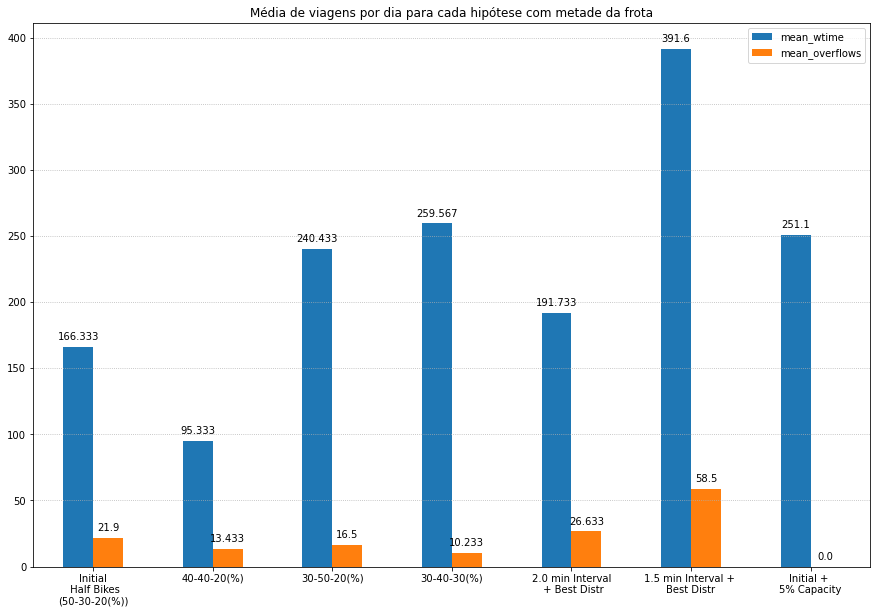

In [153]:
labels = ['Initial\n Half Bikes\n(50-30-20(%))', '40-40-20(%)', '30-50-20(%)', '30-40-30(%)', '2.0 min Interval\n + Best Distr', '1.5 min Interval + \nBest Distr', 'Initial + \n5% Capacity']
title = 'Média de viagens por dia para cada hipótese com metade da frota'

ax = hps[['mean_wtime', 'mean_overflows']].loc[hps.n_bikes < 3908].plot(kind='bar', figsize=(15, 10), rot=0, title=title)
for p in ax.patches:                 
    ax.annotate(round(p.get_height(),3), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.grid(linestyle=':', axis='y')
ax.set_xticklabels(labels)

[Text(0, 0, 'Initial'),
 Text(1, 0, '1.5 min Interval'),
 Text(2, 0, '1.0 min Interval'),
 Text(3, 0, '1.0 min Interval + \nBest Distr'),
 Text(4, 0, '1.0 min Interval + \nBest Distr + \n5% Capacity'),
 Text(5, 0, '1.5 min Interval + \nBest Distr + \n5% Capacity')]

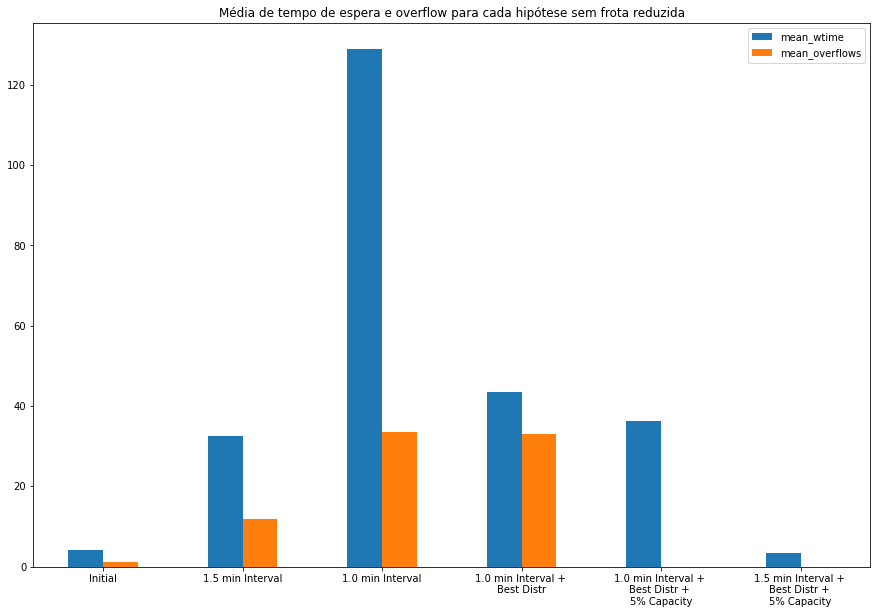

In [144]:
labels = ['Initial', '1.5 min Interval', '1.0 min Interval', '1.0 min Interval + \nBest Distr', '1.0 min Interval + \nBest Distr + \n5% Capacity', '1.5 min Interval + \nBest Distr + \n5% Capacity']
title = 'Média de tempo de espera e overflow para cada hipótese sem frota reduzida'

ax = hps[['mean_trips', 'mean_overflows']].loc[hps.n_bikes == 3908].plot(kind='bar', figsize=(15, 10), rot=0, title=title)
ax.set_xticklabels(labels)